In [1]:
import numpy as np
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import time

import grad_cam
from meanpertrub import MeanPertrub
os.chdir('../')
from model3d import mri_model
from model3d.mri_model import train, get_accuracy, get_prediction

device = torch.device('cuda:1' if torch.cuda.is_available() else'cpu')
random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
CHECKPOINTS_DIR = './checkpoints/'
isTrain = False

In [2]:
X, y = np.load('/workspace/InterpretableNeuroDL/data/tensors.npy'), np.load('/workspace/InterpretableNeuroDL/data/labels.npy')#change path 
X = X[:, None,:,:,:]
print(X.shape, y.shape)
dataset = mri_model.MriData(X, y)
C = 32

(1113, 1, 58, 70, 58) (1113,)


## Meaningful Perturbations

In [3]:
if isTrain:
    loader = torch_data.DataLoader(dataset, batch_size=30, shuffle=False)
    net = mri_model.MriNet(C).to(device)
    net.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_model_all'), map_location=device))#change path
    net = net.float()
    net.eval()
    for param in net.parameters():
        param.requires_grad = False
    pred = np.concatenate(get_prediction(net, loader, device), axis=0)
    pertrub = MeanPertrub(device)
    masks_pertrub = pertrub.get_masks(X[:2], pred[:2], net)
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_pertrub'), masks_pertrub)
else:
    masks_pertrub = np.load(os.path.join(CHECKPOINTS_DIR,'masks_pertrub.npy'))

In [4]:
man_idx = np.arange(y.shape[0])[y == 1]
woman_idx = np.arange(y.shape[0])[y == 0]
man_masks = masks_pertrub[man_idx]
man_mean_mask = np.mean(man_masks, axis=0)
woman_masks = masks_pertrub[woman_idx]
woman_mean_mask = np.mean(woman_masks, axis=0)
mean_mask = man_mean_mask + woman_mean_mask

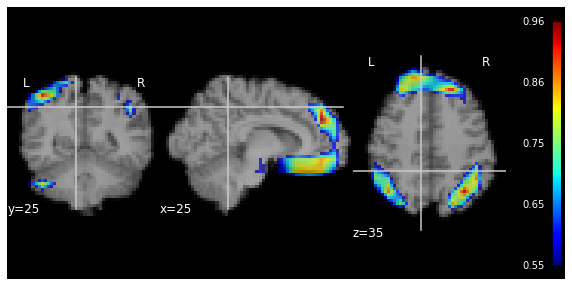

In [5]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')

In [8]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
EPOCHS = 20
m = 0
cross_mask =[]
for Mask in [man_mean_mask, woman_mean_mask, mean_mask]:
    torch.manual_seed(82)
    torch.cuda.manual_seed(82)
    np.random.seed(82)
    print('Doing {} mask'.format(m))
    m += 1
    cross_vall_acc_list = []
    j = 0
    for train_index, test_index in skf.split(X, y,):
        print('Doing {} split'.format(j))
        j += 1
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        train_dataset = mri_model.MriData(X_train, y_train)
        val_dataset = mri_model.MriData(X_test * Mask, y_test)
        train_loader = torch_data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
        val_loader = torch_data.DataLoader(val_dataset, batch_size=28, shuffle=False) 
        
        model = mri_model.MriNet(C).to(device)
        criterion = nn.NLLLoss( )
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    
        train(EPOCHS, model, criterion, optimizer, train_loader, val_loader,device,scheduler=scheduler, save=False, verbose=False) 
        cross_vall_acc_list.append(get_accuracy(model, val_loader, device))
    cross_mask.append(cross_vall_acc_list)
cv_acc = np.array(cross_mask)
np.save(os.path.join(CHECKPOINTS_DIR, 'cv_masks'), cv_acc)

Doing 0 mask
Doing 0 split
Doing 1 split
Doing 2 split
Doing 3 split
Doing 4 split
Doing 5 split
Doing 6 split
Doing 7 split
Doing 8 split
Doing 9 split
Doing 1 mask
Doing 0 split
Doing 1 split
Doing 2 split
Doing 3 split
Doing 4 split
Doing 5 split
Doing 6 split
Doing 7 split
Doing 8 split
Doing 9 split
Doing 2 mask
Doing 0 split
Doing 1 split
Doing 2 split
Doing 3 split
Doing 4 split
Doing 5 split
Doing 6 split
Doing 7 split
Doing 8 split
Doing 9 split


In [9]:
print('Mean cross-validation accuracy for man mask (10-folds):', np.mean(cv_acc[0]))
print('Std cross-validation accuracy for man mask (10-folds):', np.std(cv_acc[0], ddof=1))
print()
print('Mean cross-validation accuracy for woman mask (10-folds):', np.mean(cv_acc[1]))
print('Std cross-validation accuracy for woman mask (10-folds):', np.std(cv_acc[1], ddof=1))
print()
print('Mean cross-validation accuracy for conj mask (10-folds):', np.mean(cv_acc[2]))
print('Std cross-validation accuracy for conj mask (10-folds):', np.std(cv_acc[2], ddof=1))

Mean cross-validation accuracy for man mask (10-folds): 58.55131874084473
Std cross-validation accuracy for man mask (10-folds): 17.855139440353028

Mean cross-validation accuracy for woman mask (10-folds): 59.21171226501465
Std cross-validation accuracy for woman mask (10-folds): 7.450806550883195

Mean cross-validation accuracy for conj mask (10-folds): 82.4814998626709
Std cross-validation accuracy for conj mask (10-folds): 12.269369407659404


## Grad CAM

In [6]:
if isTrain:
    model = grad_cam.MriNetGrad(C).to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_model_all_grad'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    masks_grad = grad_cam.get_masks(model, loader, device, mask_type='grad_cam')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam'), masks_grad)
else:
    masks_grad = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam.npy'))

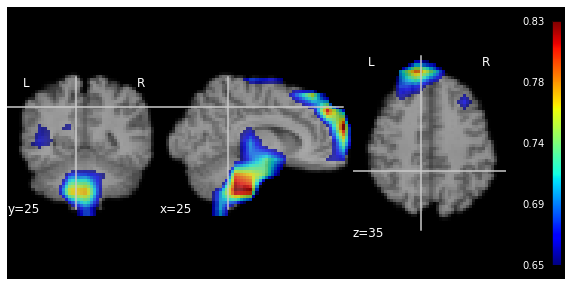

In [7]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.65)
plt.show()
fig.savefig("grad_cam.png", bbox_inches='tight')

## Guided Back-propagation

In [8]:
if isTrain:
    masks_gb = grad_cam.get_masks(model, loader, device, mask_type='guided_backprop')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb'), masks_gb)
else:
    masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb.npy'))

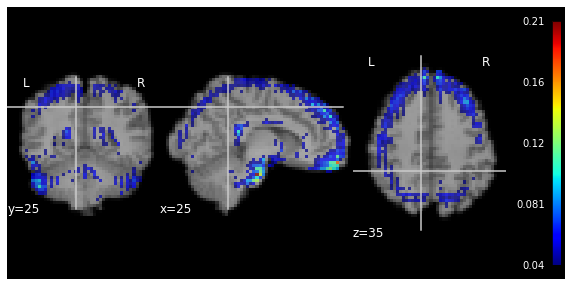

In [9]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.04)
plt.show()
fig.savefig("guided backpropagation.png", bbox_inches='tight')

## DICE

In [10]:
def dice(x, y):
    overlap = x == y
    return 2 * overlap.sum() / (x.size + y.size)

In [17]:
p_g = dice(mean_mask > 0.65, masks_grad.mean(axis=0) > 0.65)
print('Dice between Meaningful Perturbations mask and Grad Cam mask', p_g)

Dice between Meaningful Perturbations mask and Grad Cam mask 0.9464922711058263


In [18]:
p_b = dice(mean_mask > 0.65, masks_gb.mean(axis=0) > 0.04)
print('Dice between Meaningful Perturbations mask and Guided Back-propagation', p_b)

Dice between Meaningful Perturbations mask and Guided Back-propagation 0.946653643621539


In [19]:
g_b = dice(masks_grad.mean(axis=0) > 0.65, masks_gb.mean(axis=0) > 0.04)
print('Dice between Meaningful Perturbations mask and Guided Back-propagation', g_b)

Dice between Meaningful Perturbations mask and Guided Back-propagation 0.9319517581110922
